In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import binscatter
import numpy as np
import pickle
import os
import geopandas as gpd
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from shapely.geometry import Point
from shapely.ops import unary_union, transform
import pyproj
import regex as re
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.regressionplots import abline_plot, plot_fit
from scipy.ndimage import gaussian_filter1d

In [3]:
color_palette = {
    "Red NCS": "#BD0835",
    "Dark Sienna": "#4D091A",
    "Sea Green Crayola": "#43FACC",
    "Tropical Rain Forest": "#037357",
    "Jungle Green": "#11A882",
    "Oxford Blue": "#14213D",
    "Orange Web": "#FCA311",
    "Harvest Gold": "#DE8A02",
    "Air Superiority Blue": "#729DBF", # Deuteranomoly
    "Alloy Orange": "#B8590D" # Deuteranomoly
}

figure_directory = r"../Figures"
os.chdir(figure_directory)

### Figure 1 - Rent and Price Gradients across top 30 MSAs
See STATA Code

### Figure 2 - Price and Rent Growth, NYC and SF

In [4]:
with open(r'..\Data\Intermediate\fig2_data.pickle', 'rb') as handle:
    test  = pickle.load(handle)
with open(r'..\Data\Intermediate\msa_centers.pickle', 'rb') as handle:
    msa_centers = pickle.load(handle)

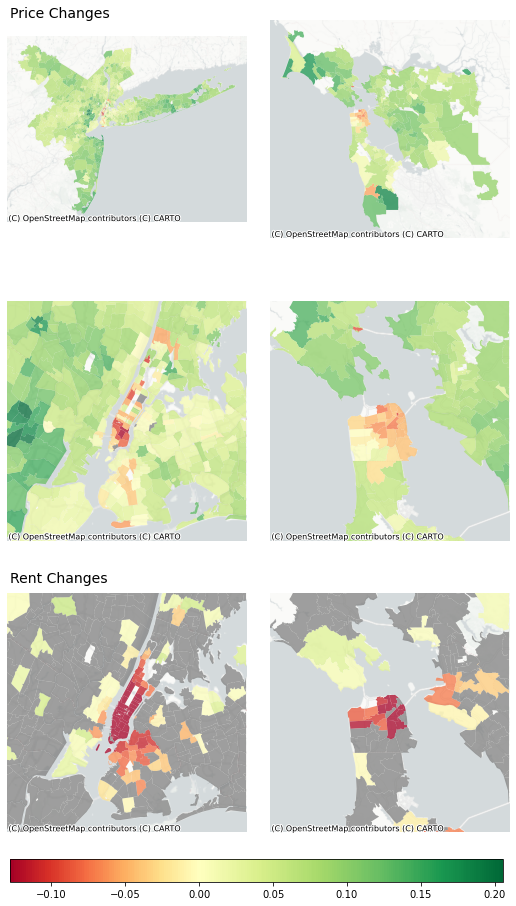

In [5]:
MSA_OI = {
    "New York-Newark-Jersey City, NY-NJ-PA": "New York City",
    "San Francisco-Oakland-Berkeley, CA": "San Francisco"
}

vmin, vmax = test[test['CBSA'].isin(MSA_OI)].log_change_zhvi.min(), test[test['CBSA'].isin(MSA_OI)].log_change_zhvi.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
margin = 30_000

fig, axs = plt.subplots(3, len(MSA_OI), figsize = (9, 16))
for i, msa in enumerate(MSA_OI):
    
    # Select data for this MSA
    temp = test[test['CBSA'] == msa]
    
    # Plot ZHVI for entire MSA
    temp.plot(column = 'log_change_zhvi',
          ax = axs[0,i],
          legend = False,
          missing_kwds = {'facecolor': "gray"},
          cmap = "RdYlGn",
          norm = norm,
          aspect = 'equal',
          alpha = 0.75)
    ctx.add_basemap(ax = axs[0,i], source = ctx.providers.CartoDB.PositronNoLabels)
    axs[0,i].axis('off')
    
    # Plot ZHVI for downtown
    temp.plot(column = 'log_change_zhvi',
          ax = axs[1,i],
          legend = False,
          missing_kwds = {'facecolor': "gray"},
          cmap = "RdYlGn",
          norm = norm,
          aspect = 'equal',
          alpha = 0.75)
    ctx.add_basemap(ax = axs[1,i], source = ctx.providers.CartoDB.PositronNoLabels)
    axs[1,i].set_xlim(left = msa_centers[msa].x - margin, right = msa_centers[msa].x + margin)
    axs[1,i].set_ylim(bottom = msa_centers[msa].y - margin, top = msa_centers[msa].y + margin)
    axs[1,i].axis('off')
    
    # Plot ZORI for downtown
    temp.plot(column = 'log_change_zori',
          ax = axs[2,i],
          legend = False,
          missing_kwds = {'facecolor': "gray"},
          cmap = "RdYlGn",
          norm = norm,
          aspect = 'equal',
          alpha = 0.75)
    ctx.add_basemap(ax = axs[2,i], source = ctx.providers.CartoDB.PositronNoLabels)
    axs[2,i].set_xlim(left = msa_centers[msa].x - margin, right = msa_centers[msa].x + margin)
    axs[2,i].set_ylim(bottom = msa_centers[msa].y - margin, top = msa_centers[msa].y + margin)
    axs[2,i].axis('off')
    
fig.subplots_adjust(bottom=0.12)
cbar_ax = fig.add_axes([0.13, 0.1, 0.76, 0.02])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="RdYlGn"), cax = cbar_ax, orientation = 'horizontal')
plt.subplots_adjust(wspace=0.1, hspace=0)

plt.figtext(0.13,0.86, "Price Changes", ha="left", va="top", fontsize=14)
plt.figtext(0.13,0.37, "Rent Changes", ha="left", va="top", fontsize=14)

plt.savefig("Cng_price-rent_MAP_nyc_expanded.pdf", bbox_inches = "tight")

### Figure 3 - Changes in Prices and Rents

In [6]:
df = pd.read_stata(r"..\Data\Intermediate\grad.dta")

In [7]:
def plot_yty_ch_dist(df, x, y, color_1, color_2, ylab, name, alpha = 0.1, xright = None, ytop = None, ybottom = None, h = 8, w = 6):
    fig, ax = plt.subplots(figsize = (h, w))

    data = df.dropna(subset = [y, x])

    ax.scatter(data = data[data['month'] == '2020-12-01'],
                y = y, x = x,
                alpha = alpha, color = color_1, marker = "x"
               )
    
    ax.scatter(data = data[data['month'] == '2019-12-01'],
                y = y, x = x,
                alpha = alpha - 0.02, color = color_2, marker = "x"
               )
    
    ax.binscatter(y = data[data['month'] == '2020-12-01'][y],
                  x = data[data['month'] == '2020-12-01'][x],
                  scatter_kwargs = {"color": color_1, "s":50, "edgecolor": "white"},
                  line_kwargs = {"color": color_1})

    ax.binscatter(y = data[data['month'] == '2019-12-01'][y],
                  x = data[data['month'] == '2019-12-01'][x],
                  scatter_kwargs = {"color": color_2, "s":50, "edgecolor": "white"},
                  line_kwargs = {"color": color_2})

    plt.legend(labels = ["Dec 2020", "Dec 2019"], prop = {"size":14})

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Set the x and y titles
    ax.set_xlabel('Log(1 + Distance) from City Center', fontsize=14)
    ax.set_ylabel(ylab, fontsize=14)

    # Set x limits
    ax.set_xlim((0, xright))
    ax.set_ylim((ybottom, ytop))

    plt.savefig(name)

In [8]:
def plot_ch_dist(df, x, y, color, xlab, ylab, name, month = '2020-12-01', alpha = 0.1, left_x = 0, right_x = None, bottom_y = None, top_y = None, h = 8, w = 6):
    fig, ax = plt.subplots(figsize = (h, w))

    data = df.dropna(subset = [y, x])

    ax.scatter(data = data[data['month'] == month],
                y = y, x = x,
                alpha = alpha - 0.02, color = color, marker = "x"
               )
    ax.binscatter(y = data[data['month'] == month][y],
                  x = data[data['month'] == month][x],
                  scatter_kwargs = {"color": color, "s":50, "edgecolor": "white"},
                  line_kwargs = {"color": color})

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Set the x and y titles
    ax.set_xlabel(xlab, fontsize=14)
    ax.set_ylabel(ylab, fontsize=14)

    # Set x limits
    ax.set_xlim(left = left_x, right = right_x)
    ax.set_ylim(bottom = bottom_y, top = top_y)

    plt.savefig(name)

#### Panel A - Rent (Bid-Rent Curve)

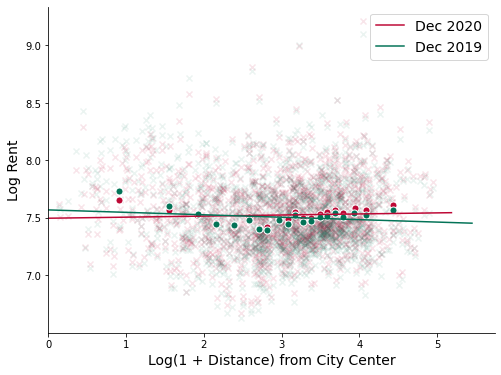

In [9]:
plot_yty_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ZORI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Rent', 
    name = "top30_zori_l.pdf"
)

#### Panel B - Price (Bid-Rent Curve)

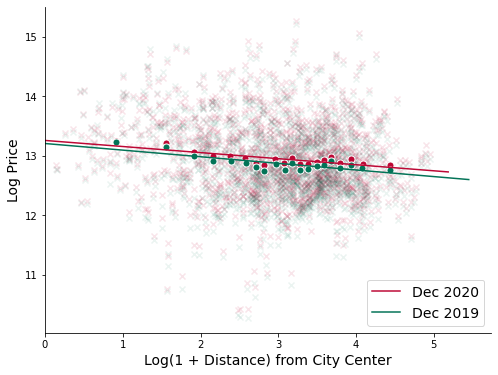

In [10]:
plot_yty_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ZHVI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Price', 
    name = "top30_zhvi_l.pdf"
)

#### Panel C - Rent (Changes Against Distance)

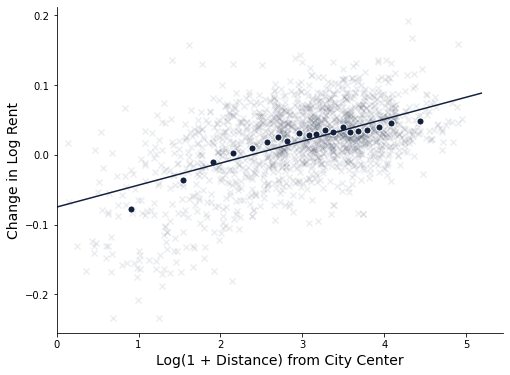

In [11]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ld_ZORI_log',
    color_palette["Oxford Blue"], 
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Rent',
    name = "top30_perc_log_rent_dist.pdf"
)

#### Panel D - Price (Changes Against Distance)

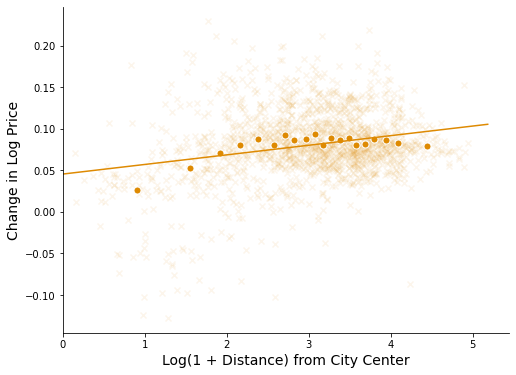

In [12]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ld_ZHVI_log',
    color_palette["Harvest Gold"], 
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Price',
    name = "top30_perc_log_price_dist_p.pdf"
)

#### Panel E - Rent (Changes Against Pre-Pandemic Levels)

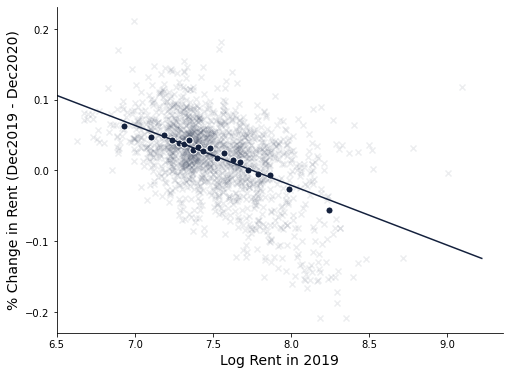

In [13]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'll12_ZORI_log', 'pc_ZORI_',
    color_palette["Oxford Blue"], left_x = 6.5,
    xlab = 'Log Rent in 2019', ylab = '% Change in Rent (Dec2019 - Dec2020)',
    name = "top30_perc_log_rent.pdf"
)

#### Panel F - Price (Changes Against Pre-Pandemic Levels)

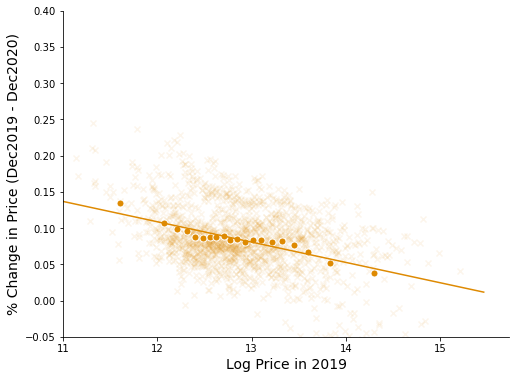

In [14]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'll12_ZHVI_log', 'pc_ZHVI_',
    color_palette["Harvest Gold"], left_x = 11,
    bottom_y = -0.05, top_y = 0.4,
    xlab = 'Log Price in 2019', ylab = '% Change in Price (Dec2019 - Dec2020)',
    name = "top30_perc_log_price_p.pdf"
)

### Figure 4 - Robustness in Bid-Rent Curve Estimation Across Price
See STATA Code

### Figure 5 - MSA level Changes in Price and Rent Gradients

In [15]:
with open(r'..\Data\Intermediate\fig5_data.pickle', 'rb') as handle:
    gdf  = pickle.load(handle)

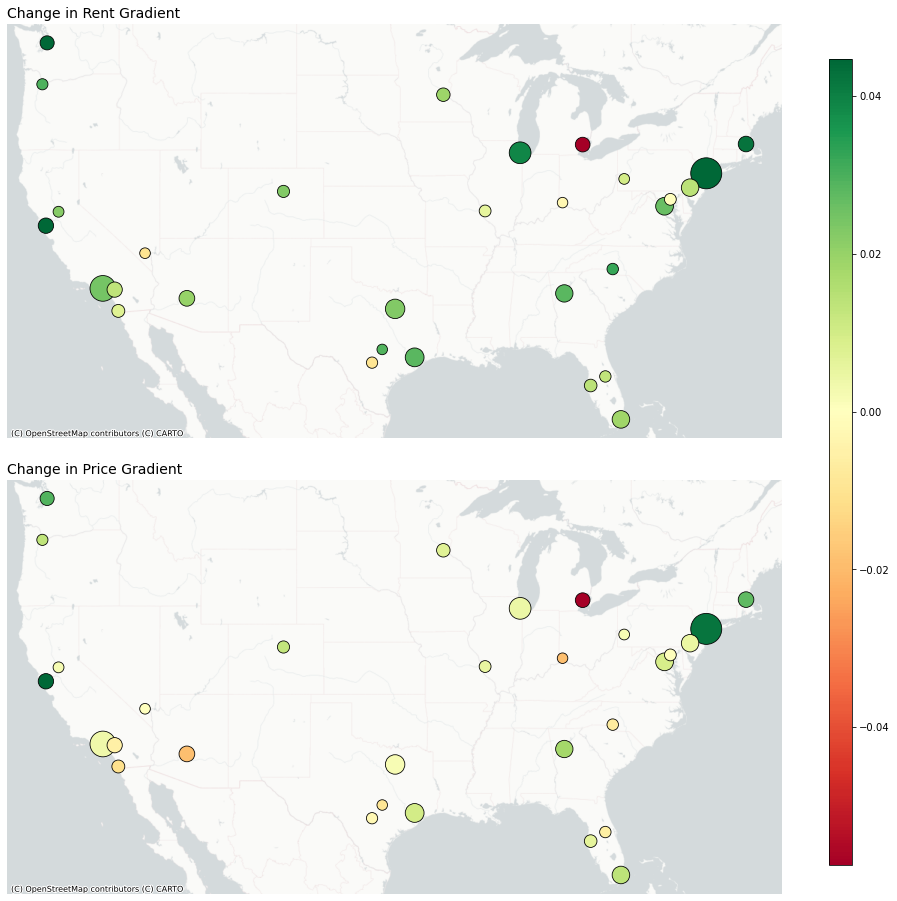

In [16]:
vmin, vmax = gdf.delta_grad_zhvi.min(), gdf.delta_grad_zhvi.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, axs = plt.subplots(2, 1, figsize = (16, 16))

gdf \
    .plot(column = 'delta_grad_zhvi', 
          legend = False, 
          missing_kwds = {'facecolor': "gray"},
          ax = axs[1],
          cmap = "RdYlGn",
          norm = norm,
          aspect = 'equal',
          alpha = 1,
          edgecolors = "black",
          linewidths = 0.8,
          markersize = 'marker_size')
ctx.add_basemap(axs[1], source = ctx.providers.CartoDB.PositronNoLabels)
axs[1].axis('off')
axs[1].set_title("Change in Price Gradient", fontsize = 14, ha = 'left', loc='left')

gdf \
    .plot(column = 'delta_grad_zori', 
          legend = False, 
          missing_kwds = {'facecolor': "gray"},
          ax = axs[0],
          cmap = "RdYlGn",
          norm = norm,
          aspect = 'equal',
          alpha = 1,
          edgecolors = "black",
          linewidths = 0.8,
          markersize = 'marker_size')
ctx.add_basemap(axs[0], source = ctx.providers.CartoDB.PositronNoLabels)
axs[0].axis('off')
axs[0].set_title("Change in Rent Gradient", fontsize = 14, ha = 'left', loc='left')

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="RdYlGn"), cax = cbar_ax, orientation = 'vertical')
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig(f"chg_grad_us.pdf", bbox_inches = "tight")

### Figure 6 - Changes in Listing Prices and Market Inventory

In [17]:
df = pd.read_stata(r"..\Data\Intermediate\grad.dta")

#### Panel A - Median Listing Price

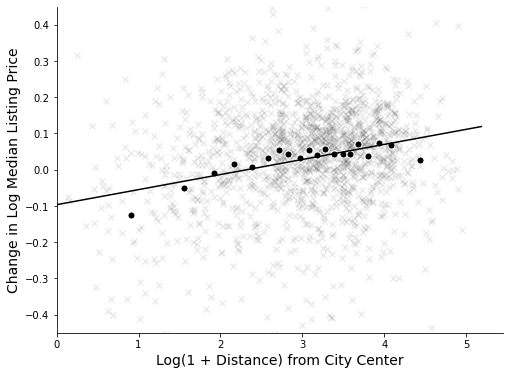

In [18]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ld_rltr_mlp_log',
    'black', bottom_y = -0.45, top_y = 0.45,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price',
    name = "top30_perc_mlp_dist.pdf"
)

#### Panel B - Median Listing Price per sq. ft.

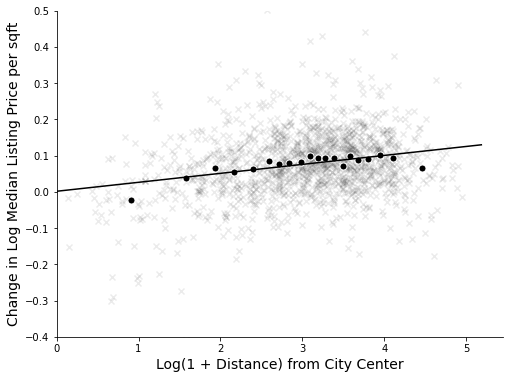

In [19]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ld_rltr_med_list_ppsqft_log',
    'black', bottom_y = -0.4, top_y = 0.5,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price per sqft',
    name = "top30_perc_mlp_sqft_dist.pdf"
)

#### Panel C - Active Listings

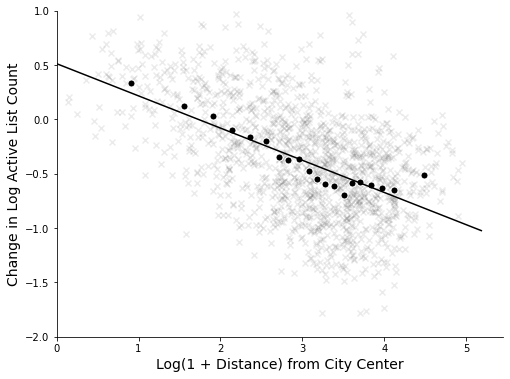

In [20]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ld_rltr_act_list_count_log',
    'black', bottom_y = -2, top_y = 1,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Active List Count',
    name = "top30_act_list_count_dist.pdf"
)

#### Panel D - Median Days on Market

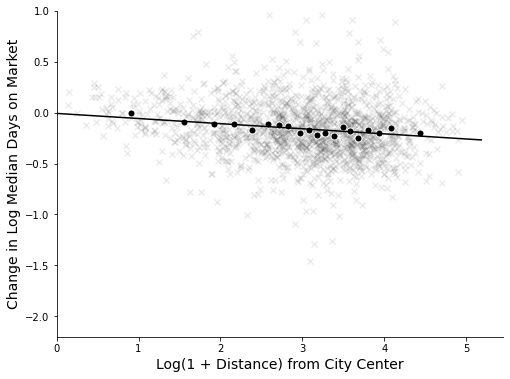

In [21]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'distance_log', 'ld_rltr_med_dom_log',
    'black', bottom_y = -2.2, top_y = 1,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Days on Market',
    name = "top30_med_dom_dist.pdf"
)

### Figure 7 - Price Change against Changes in Inventory

#### Panel A - Price change against active listing changes

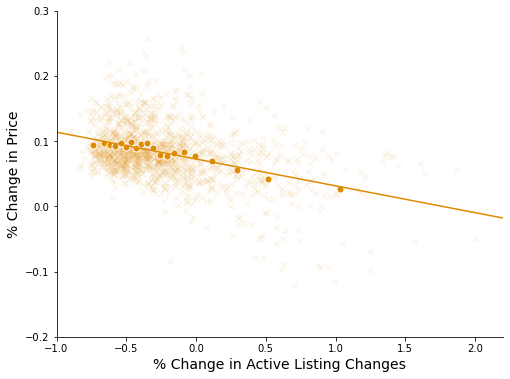

In [22]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'pc_rltr_act_list_count_', 'pc_ZHVI_',
    color_palette["Harvest Gold"], left_x = -1, right_x = 2.2, bottom_y = -0.2, top_y = 0.3,
    xlab = '% Change in Active Listing Changes', ylab = '% Change in Price',
    name = "zhvi_acl_all2.pdf"
)

#### Panel B - Price and median days on market changes

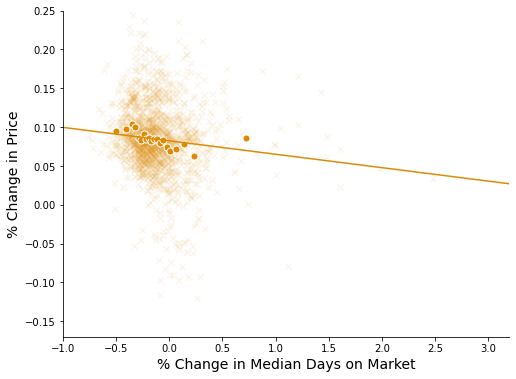

In [23]:
plot_ch_dist(
    df[(df['n'] <= 30) & (df['zori_av'] == 1)], 'pc_rltr_med_dom_', 'pc_ZHVI_',
    color_palette["Harvest Gold"], left_x = -1, right_x = 3.2, bottom_y = -0.17, top_y = 0.25,
    xlab = '% Change in Median Days on Market', ylab = '% Change in Price',
    name = "zhvi_mdom_all2.pdf"
)

### Figure 8 - Associations of Intracity Migration

#### Panel A - Migration Against Distance

#### Panel B - Migration Against Work From Home

#### Panel C - Migration Against Rent

#### Panel D - Migration Against Price

### Figure 9 - Out-Migration Rates Using VenPath Data

### Figure 10 - Out-Migration Rates Using Infutor Data

### Figure 11 - Price-Rent Ratio against Distance for New York

In [29]:
df2 = pd.read_stata(r"..\Data\Intermediate\pdratios.dta")

In [30]:
def plot_post_vs_pre(df, x, y1, y2, color_1, color_2, ylab, name, h = 8, w = 6):
    fig, ax = plt.subplots(figsize = (h, w))

    data = df.dropna(subset = [y1, y2, x])

    ax.scatter(data = data[data['month'] == '2020-12-01'],
                y = y1, x = x,
                alpha = 0.3, color = color_1, marker = "x"
               )
    ax.binscatter(y = data[data['month'] == '2020-12-01'][y1],
                  x = data[data['month'] == '2020-12-01'][x],
                  scatter_kwargs = {"color": color_1, "s":50, "edgecolor": "white"},
                  line_kwargs = {"color": color_1})

    ax.scatter(data = data[data['month'] == '2020-12-01'],
                y = y2, x = x,
                alpha = 0.3, color = color_2, marker = "x"
               )
    ax.binscatter(y = data[data['month'] == '2020-12-01'][y2],
                  x = data[data['month'] == '2020-12-01'][x],
                  scatter_kwargs = {"color": color_2, "s":50, "edgecolor": "white"},
                  line_kwargs = {"color": color_2})

    plt.legend(labels = ["Pre-Pandemic", "Post-Pandemic"], prop={"size":14})

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Set the x and y titles
    ax.set_xlabel('Log(1 + Distance) from New York Center', fontsize=14)
    ax.set_ylabel(ylab, fontsize=14)

    # Set x limits
    ax.set_xlim(left = 0)

    plt.savefig(name)

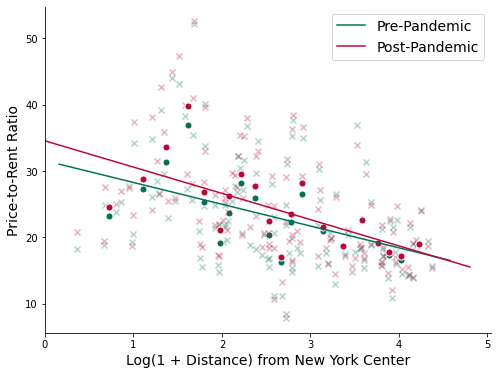

In [55]:
plot_post_vs_pre(
    df2[df2['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'pd_pre', 'pd_post', 
    color_palette["Tropical Rain Forest"], color_palette["Red NCS"], 
    ylab = 'Price-to-Rent Ratio',
    name = "NY_pd2.pdf"
)

### Figure 12 - Changes in Rent and Price Growth Rates

In [32]:
df2 = pd.read_stata(r"..\Data\Intermediate\pdratios.dta")

#### Panel A - Rent Growth

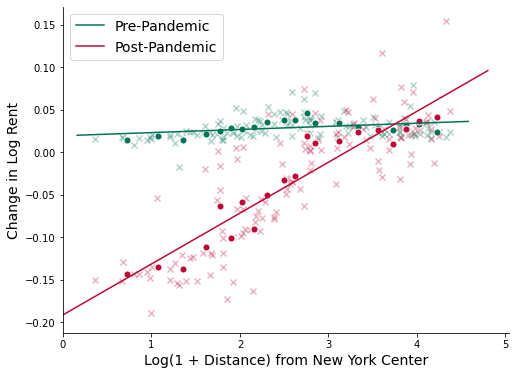

In [33]:
plot_post_vs_pre(
    df2[df2['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ch_ZORI_log_pre', 'ch_ZORI_log_post', 
    color_palette["Tropical Rain Forest"], color_palette["Red NCS"], 
    ylab = 'Change in Log Rent',
    name = "NY_rentgrowth2.pdf"
)

#### Panel B - Price Growth

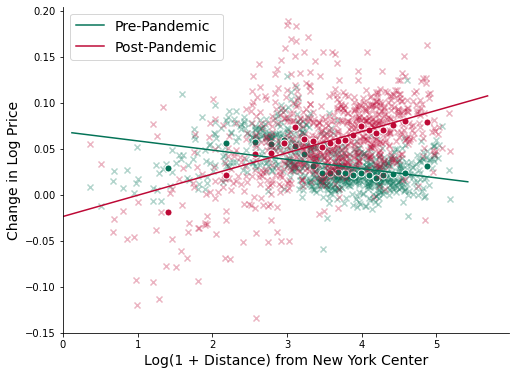

In [34]:
plot_post_vs_pre(
    df2[df2['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ch_ZHVI_log_pre', 'ch_ZHVI_log_post', 
    color_palette["Tropical Rain Forest"], color_palette["Red NCS"], 
    ylab = 'Change in Log Price',
    name = "NY_pricegrowth2.pdf"
)

### Figure 13 - Evolution of Rent Growth when Pandemic is Transitory and Permanent along with a Combination of Two Regimes
See STATA Code

### Figure A1 - Bid-rent Functions for San Francisco and New York

In [35]:
df = pd.read_stata(r"..\Data\Intermediate\grad.dta")

#### Panel A - New York - Rent

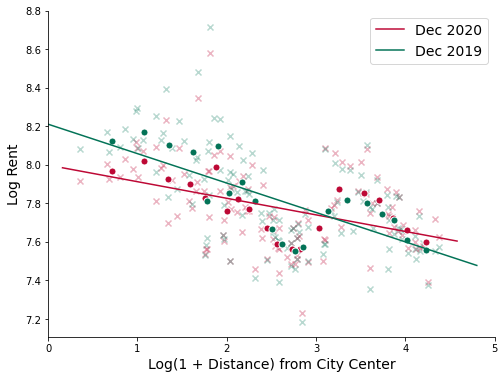

In [36]:
plot_yty_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ZORI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Rent', alpha = 0.3,
    ytop = 8.8, xright = 5,
    name = "New_York-Newark-Jersey_City,_NY-NJ-PA_zori_l.pdf"
)

#### Panel B - New York - Price

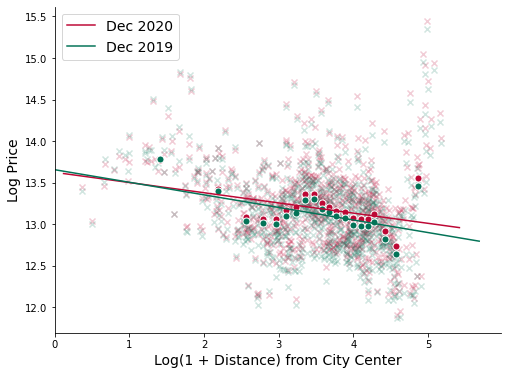

In [37]:
plot_yty_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ZHVI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Price', alpha = 0.2,
    name = "New_York-Newark-Jersey_City,_NY-NJ-PA_zhvi_l.pdf"
)

#### Panel C - San Francisco - Rent

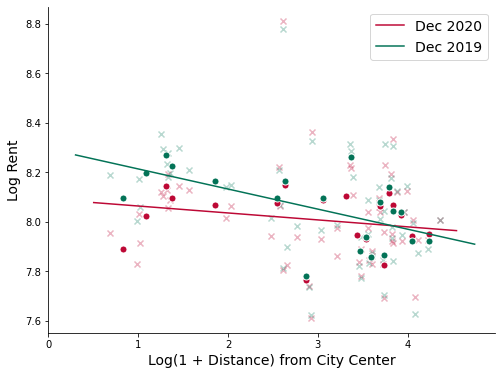

In [38]:
plot_yty_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'distance_log', 'ZORI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Rent', alpha = 0.3,
    name = "San_Francisco-Oakland-Berkeley,_CA_zori_l.pdf"
)

#### Panel D - San Francisco - Price

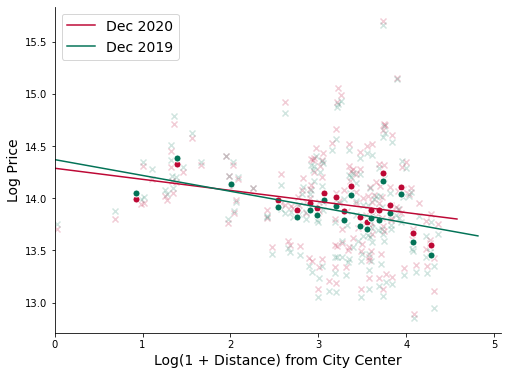

In [39]:
plot_yty_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'distance_log', 'ZHVI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Price', alpha = 0.2,
    name = "San_Francisco-Oakland-Berkeley,_CA_zhvi_l.pdf"
)

### Figure A2 -  Changes in Bid-rent function

#### Panel A - Rent

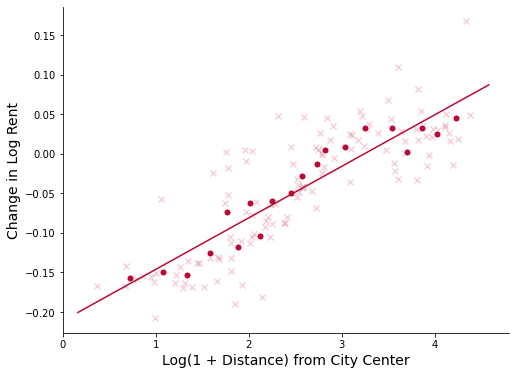

In [40]:
plot_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ld_ZORI_log',
    color_palette["Red NCS"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Rent',
    name = "New_York-Newark-Jersey_City,_NY-NJ-PA_zori_ld.pdf"
)

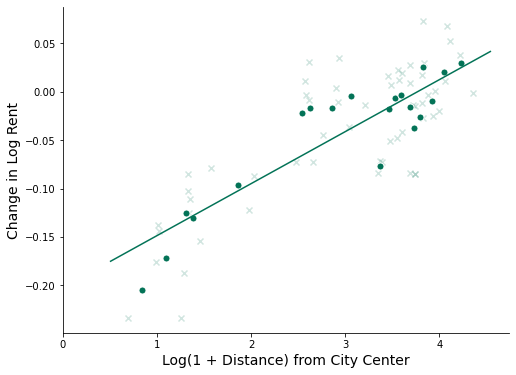

In [41]:
plot_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'distance_log', 'ld_ZORI_log',
    color_palette["Tropical Rain Forest"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Rent',
    name = "San_Francisco-Oakland-Berkeley,_CA_zori_ld.pdf"
)

#### Panel B - Price

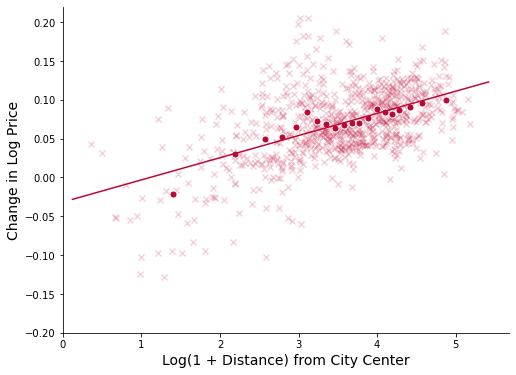

In [42]:
plot_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ld_ZHVI_log',
    color_palette["Red NCS"], alpha = 0.2,
    bottom_y = -0.2, top_y = 0.22,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Price',
    name = "New_York-Newark-Jersey_City,_NY-NJ-PA_zhvi_ld.pdf"
)

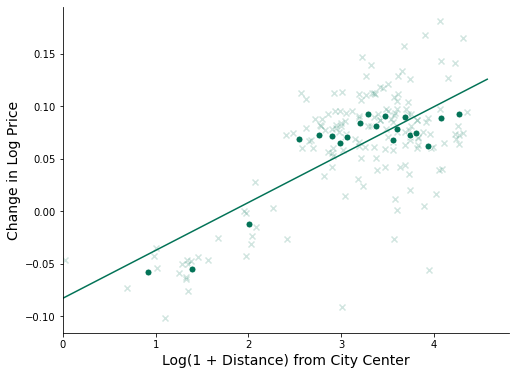

In [43]:
plot_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'distance_log', 'ld_ZHVI_log',
    color_palette["Tropical Rain Forest"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Price',
    name = "San_Francisco-Oakland-Berkeley,_CA_zhvi_ld.pdf"
)

### Figure A3 - Changes in Rents and Prices Against Pre-Pandemic Levels

#### Panel A - Rent

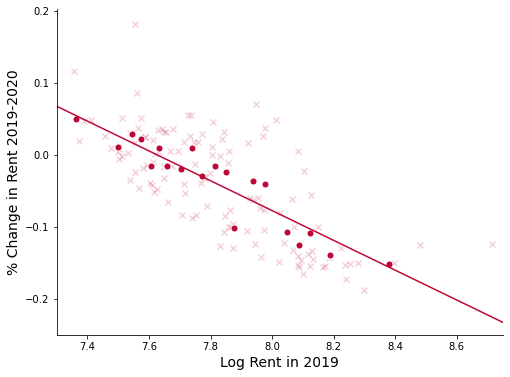

In [44]:
plot_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'll12_ZORI_log', 'pc_ZORI_',
    color_palette["Red NCS"], alpha = 0.2, left_x = 7.3, right_x = 8.75, bottom_y = -0.25,
    xlab = 'Log Rent in 2019', ylab = '% Change in Rent 2019-2020',
    name = "nyrent_voxeu.pdf"
)

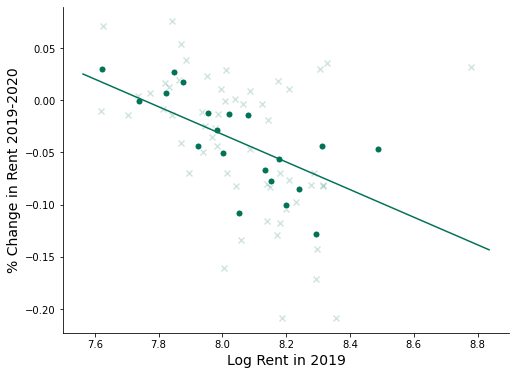

In [45]:
plot_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'll12_ZORI_log', 'pc_ZORI_',
    color_palette["Tropical Rain Forest"], alpha = 0.2, left_x = 7.5,
    xlab = 'Log Rent in 2019', ylab = '% Change in Rent 2019-2020',
    name = "sfrent_voxeu.pdf"
)

#### Panel B - Price

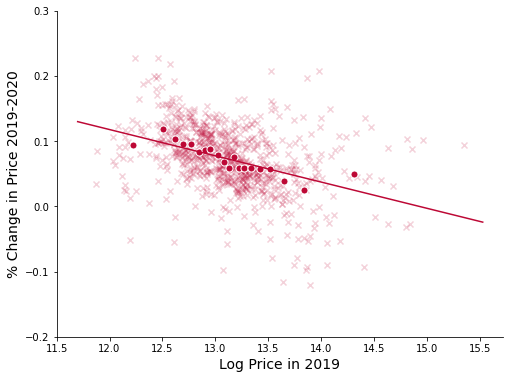

In [46]:
plot_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'll12_ZHVI_log', 'pc_ZHVI_',
    color_palette["Red NCS"], alpha = 0.2, left_x = 11.5, bottom_y = -0.2, top_y = 0.3,
    xlab = 'Log Price in 2019', ylab = '% Change in Price 2019-2020',
    name = "nyprice_voxeu.pdf"
)

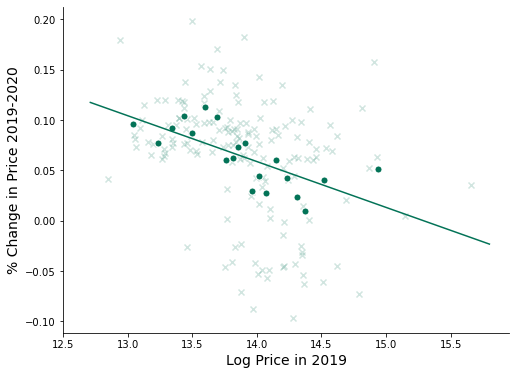

In [47]:
plot_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'll12_ZHVI_log', 'pc_ZHVI_',
    color_palette["Tropical Rain Forest"], alpha = 0.2, left_x = 12.5,
    xlab = 'Log Price in 2019', ylab = '% Change in Price 2019-2020',
    name = "sfprice_voxeu.pdf"
)

### Figure A4 - Pandemic Induced Changes in Prices and Rents without Sample Restrictions

In [48]:
df = pd.read_stata(r"..\Data\Intermediate\grad.dta")

#### Panel A - Rent (Bid-Rent Curve)

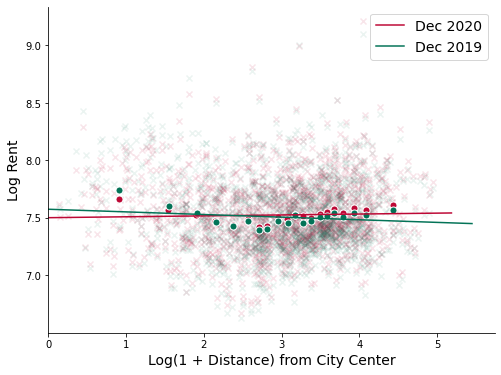

In [49]:
plot_yty_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ZORI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Rent', 
    name = "top30_zori_l_tot.pdf"
)

#### Panel B - Price (Bid-Rent Curve)

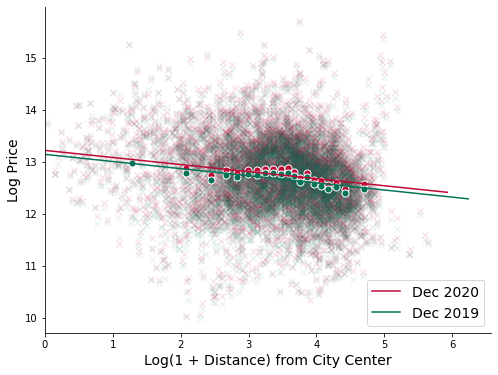

In [50]:
plot_yty_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ZHVI_log',
    color_palette["Red NCS"], color_palette["Tropical Rain Forest"], 
    ylab = 'Log Price', 
    name = "top30_zhvi_l_tot.pdf"
)

#### Panel C - Rent (Changes Against Distance)

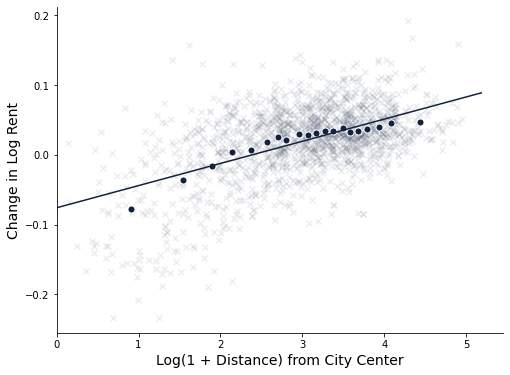

In [51]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ld_ZORI_log',
    color_palette["Oxford Blue"], 
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Rent',
    name = "top30_perc_log_rent_dist_tot.pdf"
)

#### Panel D - Price (Changes Against Distance)

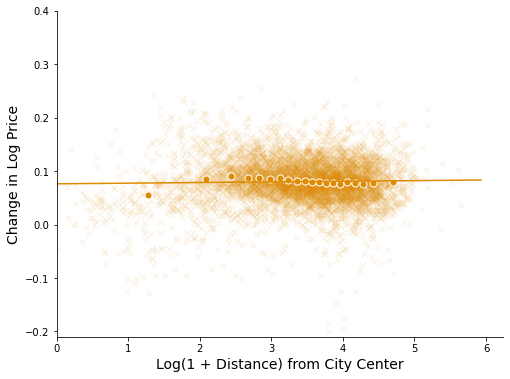

In [52]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ld_ZHVI_log',
    color_palette["Harvest Gold"], 
    bottom_y = -0.21, top_y = 0.4,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Price',
    name = "top30_perc_log_price_dist_p_tot.pdf"
)

#### Panel E - Rent (Changes Against Pre-Pandemic Levels)

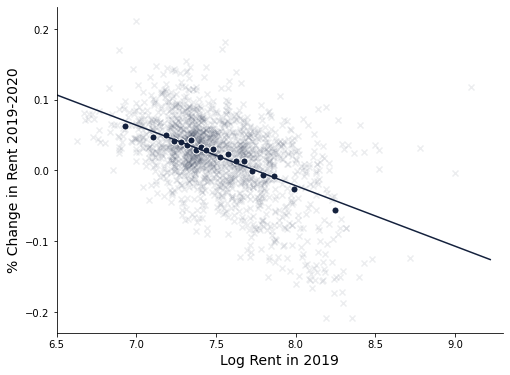

In [53]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'll12_ZORI_log', 'pc_ZORI_',
    color_palette["Oxford Blue"], left_x = 6.5, right_x = 9.3,
    xlab = 'Log Rent in 2019', ylab = '% Change in Rent 2019-2020',
    name = "top30_perc_log_rent_tot.pdf"
)

#### Panel F - Price (Changes Against Pre-Pandemic Levels)

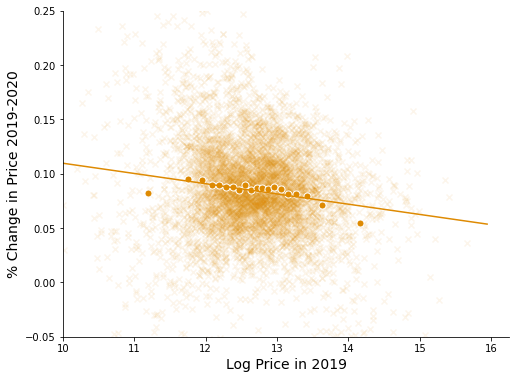

In [54]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'll12_ZHVI_log', 'pc_ZHVI_',
    color_palette["Harvest Gold"], left_x = 10,
    bottom_y = -0.05, top_y = 0.25,
    xlab = 'Log Price in 2019', ylab = '% Change in Price 2019-2020',
    name = "top30_perc_log_price_p_tot.pdf"
)

### Figure A5 - Changes in Listing Prices and Market Inventory without Sample Restrictions

#### Panel A - Median Listing Price

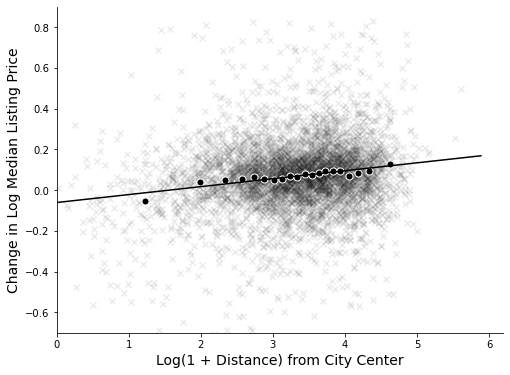

In [56]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ld_rltr_mlp_log',
    'black', bottom_y = -0.7, top_y = 0.9,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price',
    name = "top30_perc_mlp_dist_tot.pdf"
)

#### Panel B - Median Listing Price per sq. ft.

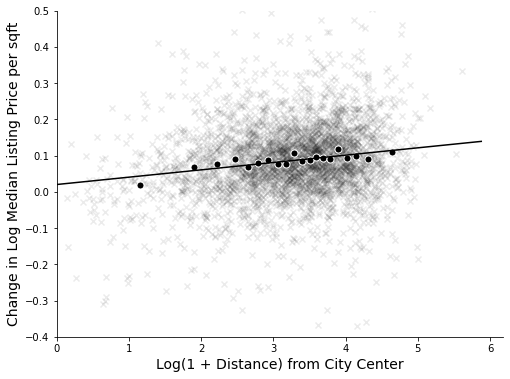

In [57]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ld_rltr_med_list_ppsqft_log',
    'black', bottom_y = -0.4, top_y = 0.5,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price per sqft',
    name = "top30_perc_mlp_sqft_dist_tot.pdf"
)

#### Panel C - Active Listings

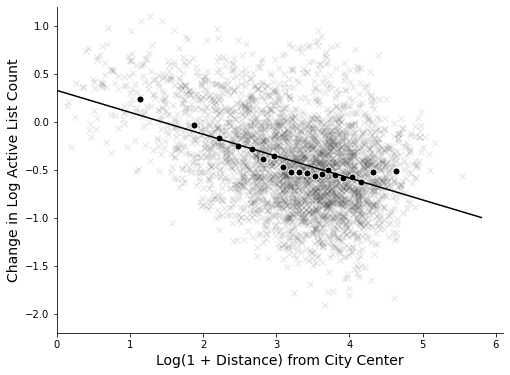

In [58]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ld_rltr_act_list_count_log',
    'black', bottom_y = -2.2, top_y = 1.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Active List Count',
    name = "top30_act_list_count_dist_tot.pdf"
)

#### Panel D - Median Days on Market

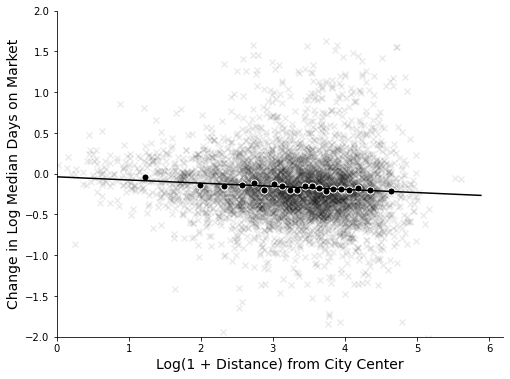

In [59]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'distance_log', 'ld_rltr_med_dom_log',
    'black', bottom_y = -2, top_y = 2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Days on Market',
    name = "top30_med_dom_dist_tot.pdf"
)

### Figure A6 - Changes in Listing Prices and Market Inventory

#### Panel A - Median Listing Price

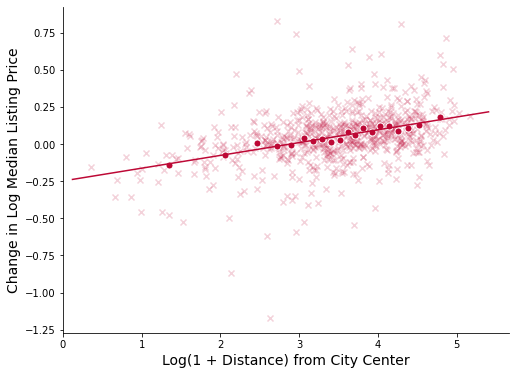

In [60]:
plot_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ld_rltr_mlp_log',
    color_palette["Red NCS"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price',
    name = "New_York-Newark-Jersey_City,_NY-NJ-PA_mlp_ld.pdf"
)

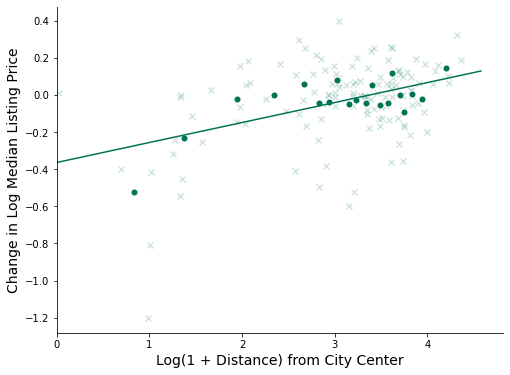

In [61]:
plot_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'distance_log', 'ld_rltr_mlp_log',
    color_palette["Tropical Rain Forest"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price',
    name = "San_Francisco-Oakland-Berkeley,_CA_mlp_ld.pdf"
)

#### Panel B - Median Listing Price per sq. ft.

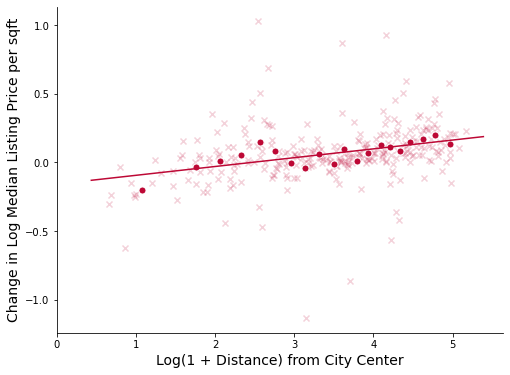

In [62]:
plot_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ld_rltr_med_list_ppsqft_log',
    color_palette["Red NCS"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price per sqft',
    name = "New_York-Newark-Jersey_City,_NY-NJ-PA_mlppsqft_ld.pdf"
)

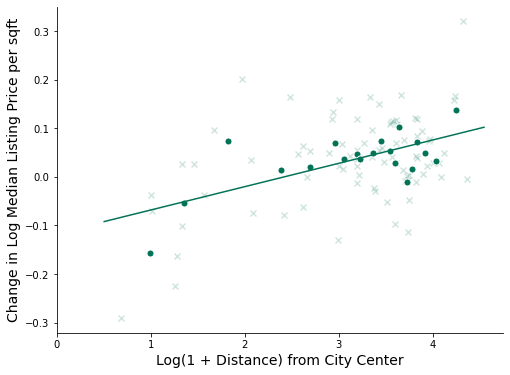

In [63]:
plot_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'distance_log', 'ld_rltr_med_list_ppsqft_log',
    color_palette["Tropical Rain Forest"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Median Listing Price per sqft',
    name = "San_Francisco-Oakland-Berkeley,_CA_mlppsqft_ld.pdf"
)

#### Panel C - Active Listings

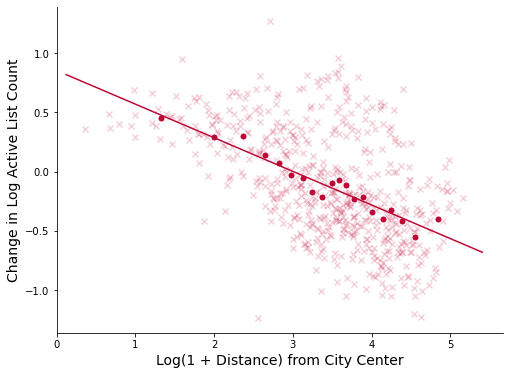

In [64]:
plot_ch_dist(
    df[df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA"], 
    'distance_log', 'ld_rltr_act_list_count_log',
    color_palette["Red NCS"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Active List Count',
    name = "New_York-Newark-Jersey_City,_NY-NJ-PA_act_ld.pdf"
)

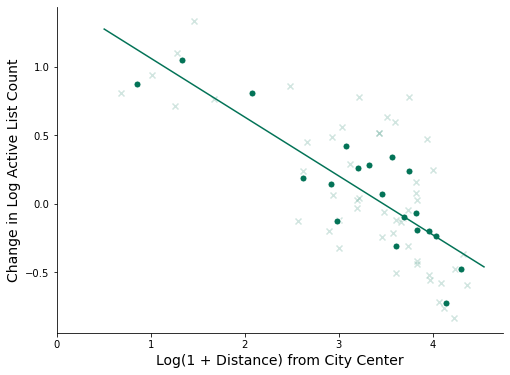

In [65]:
plot_ch_dist(
    df[df['cbsa'] == "San Francisco-Oakland-Berkeley, CA"], 
    'distance_log', 'ld_rltr_act_list_count_log',
    color_palette["Tropical Rain Forest"], alpha = 0.2,
    xlab = 'Log(1 + Distance) from City Center', ylab = 'Change in Log Active List Count',
    name = "San_Francisco-Oakland-Berkeley,_CA_act_ld.pdf"
)

### Figure A7 - Price change against Changes in Inventory without Sample Restrictions

#### Panel A - Price change against active listing changes

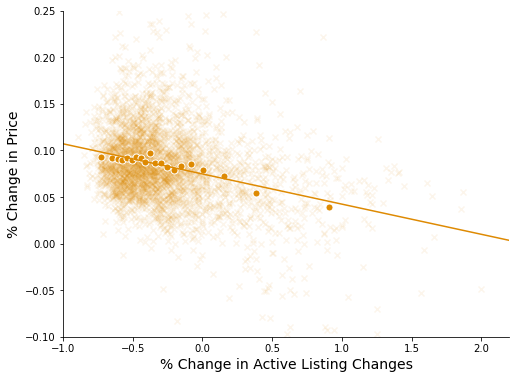

In [66]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'pc_rltr_act_list_count_', 'pc_ZHVI_',
    color_palette["Harvest Gold"], left_x = -1, right_x = 2.2, bottom_y = -0.1, top_y = 0.25,
    xlab = '% Change in Active Listing Changes', ylab = '% Change in Price',
    name = "zhvi_acl_all2_tot.pdf"
)

#### Panel B - Price and median days on market changes

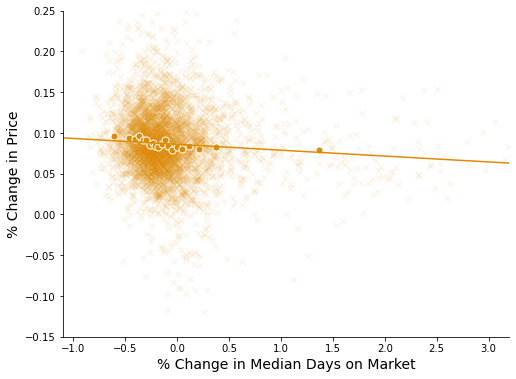

In [67]:
plot_ch_dist(
    df[(df['n'] <= 30)], 'pc_rltr_med_dom_', 'pc_ZHVI_',
    color_palette["Harvest Gold"], left_x = -1.1, right_x = 3.2, bottom_y = -0.15, top_y = 0.25,
    xlab = '% Change in Median Days on Market', ylab = '% Change in Price',
    name = "zhvi_mdom_all2_tot.pdf"
)

### Figure A8 - Population Changes by Distance From Center

#### Panel A - Baseline (6pm - 8am)

#### Panel B - (10pm - 8am)

#### Panel C - (4am - 8am)

### Figure A9 - Associations of Intracity Migration without Sample Restrictions

#### Panel A - Migration Against Distance

#### Panel B - Migration Against Work From Home

#### Panel C - Migration Against Rent

#### Panel D - Migration Against Price

### Figure A10 - Migration Against Distance, Rents, and Prices

#### Panel A - Population and Distance

#### Panel B - Population and Rent

#### Panel C - Population and Price

### Figure A11 - Net Migration Rates Using VenPath Data

### Figure A12 - Determinants of Rent and Price Gradient Changes by MSA
See stata code

### Figure A13 - Migration Rates Pre- and Post-Pandemic

In [104]:
# Load the migration data from the paper
df = pd.read_csv(r"..\Data\Intermediate\fig8_data.csv")
df['zip'] = df['zip'].astype(str).str.zfill(5)

# Load the secular population growth data from the Census Bureau
acs_mig = pd.read_stata(r"..\Data\Intermediate\secular_pop_growth.dta")

# Merge the paper data with the secular population growth numbers
df = df[['month', 'zip', 'zori_av', 'n', 'distance_log', 'log_ch_pop']].merge(acs_mig, on = 'zip', how = 'left')

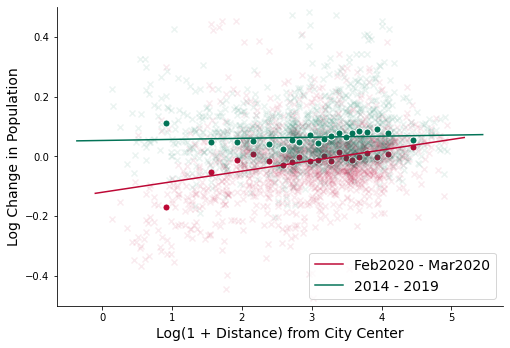

In [105]:
fig, ax = plt.subplots(figsize = (8, 5.5))

x = 'distance_log'
y_1 = 'log_ch_pop'
y_2 = 'log_chg'
color_1 = color_palette["Red NCS"] 
color_2 = color_palette["Tropical Rain Forest"]

mask = (df['month'] == '2020-03-01') & (df['n'] <= 30) & (df['zori_av'] == 1)
fig_data = df[mask].dropna(subset = [x, y_1, y_2]).reset_index()

ax.scatter(x, y_1, 
           data = fig_data,
           color = color_1, marker = 'x', alpha = 0.08)

ax.binscatter(fig_data[x], fig_data[y_1], 
              scatter_kwargs = {"color": color_1, "s":50, "edgecolor": "white"},
              line_kwargs = {"color": color_1})

ax.scatter(x, y_2,
           data = fig_data,
           color = color_2, marker = 'x', alpha = 0.08)

ax.binscatter(fig_data[x], fig_data[y_2], 
              scatter_kwargs = {"color": color_2, "s":50, "edgecolor": "white"},
              line_kwargs = {"color": color_2})

plt.legend(labels = ["Feb2020 - Mar2020", "2014 - 2019"], prop={"size":14})

# Set the axis limits
ax.set_ylim(( -0.5, 0.5))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the x and y titles
ax.set_xlabel('Log(1 + Distance) from City Center', fontsize=14)
ax.set_ylabel('Log Change in Population', fontsize=14)

plt.savefig(fr"secular_pop_growth.pdf", bbox_inches = 'tight')

### Figure A14 - Cumulative Rent Growth under Transitory Case for Top 30 MSAs, New York, San Francisco and Los Angeles

In [89]:
df = pd.read_stata(r"..\Data\Intermediate\g_zip.dta")

In [90]:
def plot_vs(df, x, y1, y2, color_1, color_2, ylab, name, alpha = 0.3, h = 8, w = 6):
    fig, ax = plt.subplots(figsize = (h, w))

    data = df.dropna(subset = [y1, y2, x])

    ax.scatter(data = data,
                y = y1, x = x,
                alpha = alpha, color = color_1, marker = "x"
               )
    ax.binscatter(y = data[y1],
                  x = data[x],
                  scatter_kwargs = {"color": color_1, "s":50, "edgecolor": "white"},
                  line_kwargs = {"color": color_1})

    ax.scatter(data = data,
                y = y2, x = x,
                alpha = alpha, color = color_2, marker = "x"
               )
    ax.binscatter(y = data[y2],
                  x = data[x],
                  scatter_kwargs = {"color": color_2, "s":50, "edgecolor": "white"},
                  line_kwargs = {"color": color_2})

    plt.legend(labels = ["Delta $x = 0$", "Delta $x = 0.01$"], prop={"size":14})

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Set the x and y titles
    ax.set_xlabel('Log(1 + Distance) from City Center', fontsize=14)
    ax.set_ylabel(ylab, fontsize=14)

    # Set x limits
    ax.set_xlim(left = 0)

    plt.savefig(name)

#### Panel A - Top 30 MSAs

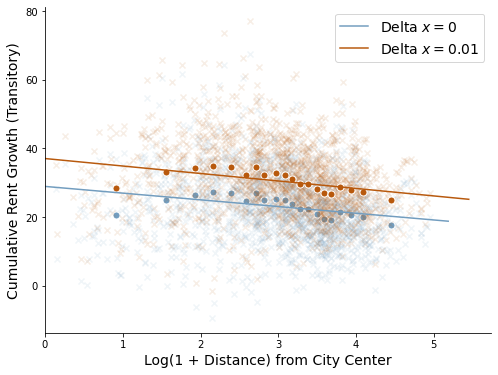

In [91]:
plot_vs(
    df[(df['n'] <= 30)], 
    'distance_log', 'cumg_chx0', 'cumg_chx001', 
    color_palette["Air Superiority Blue"], color_palette["Alloy Orange"], 
    ylab = 'Cumulative Rent Growth (Transitory)', alpha = 0.1,
    name = "Top30_cumg_py.pdf"
)

#### Panel B - New York

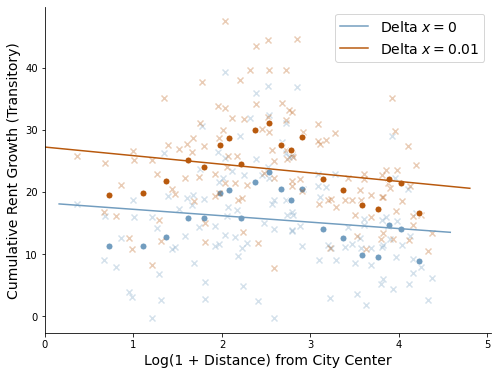

In [92]:
plot_vs(
    df[(df['cbsa'] == "New York-Newark-Jersey City, NY-NJ-PA")], 
    'distance_log', 'cumg_chx0', 'cumg_chx001', 
    color_palette["Air Superiority Blue"], color_palette["Alloy Orange"], 
    ylab = 'Cumulative Rent Growth (Transitory)',
    name = "NY_cumg_py.pdf"
)

#### Panel C - San Francisco

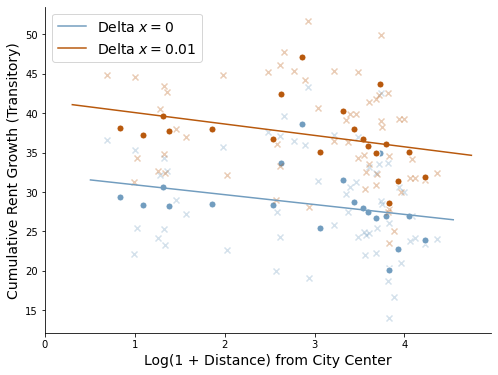

In [93]:
plot_vs(
    df[(df['cbsa'] == "San Francisco-Oakland-Berkeley, CA")], 
    'distance_log', 'cumg_chx0', 'cumg_chx001', 
    color_palette["Air Superiority Blue"], color_palette["Alloy Orange"], 
    ylab = 'Cumulative Rent Growth (Transitory)',
    name = "SF_cumg_py.pdf"
)

#### Panel D - Los Angeles

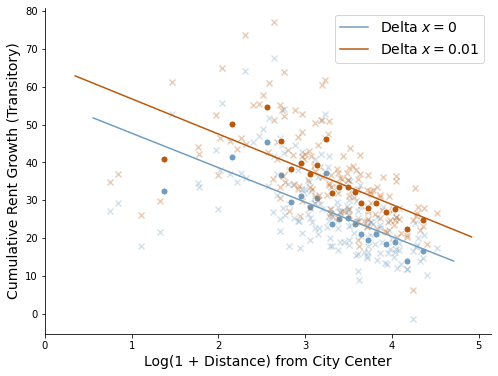

In [94]:
plot_vs(
    df[(df['cbsa'] == "Los Angeles-Long Beach-Anaheim, CA")], 
    'distance_log', 'cumg_chx0', 'cumg_chx001', 
    color_palette["Air Superiority Blue"], color_palette["Alloy Orange"], 
    ylab = 'Cumulative Rent Growth (Transitory)',
    name = "LA_cumg_py.pdf"
)

### Figure B1 - Comparing Rental Series Across Data Sets

In [95]:
fig_data = pd.read_csv(r'..\Data\Intermediate\FMR_plotdata.csv')

#### Panel A - HUD vs. ZORI

0.7975041199878925


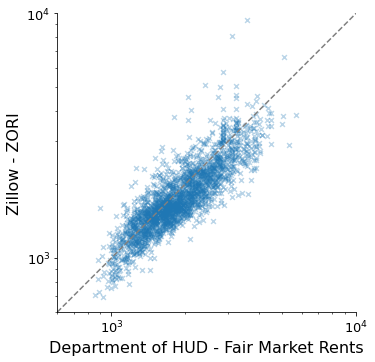

In [96]:
fig_data = fig_data[fig_data['year'] == 2020]

fig, ax = plt.subplots(figsize = (8, 5.5))

ax.scatter(
    'hud_fmr_comb', 'ZORI', data = fig_data,
    marker = 'x', s = 23, alpha = 0.3
)

corr = fig_data.loc[(fig_data['hud_fmr_comb'].notna()) & 
                    (fig_data['ZORI'].notna()),
                    'hud_fmr_comb'] \
    .corr(fig_data.loc[(fig_data['hud_fmr_comb'].notna()) & 
                    (fig_data['ZORI'].notna()),
                    'ZORI'])

mae = mean_absolute_error(fig_data['ZORI'], fig_data['hud_fmr_comb'])
print(corr)

# ax.set_title(fr"Representative Unit ($\rho$: {corr:.3f}, $MAE$: {mae:.0f})", size = 18)
ax.set_ylabel("Zillow - ZORI", size = 16)
ax.set_xlabel("Department of HUD - Fair Market Rents", size = 16)

ax.set_yscale('log')
ax.set_ylim(bottom = 0.6*1e3, top = 1e4)
ax.set_xscale('log')
ax.set_xlim(left = 0.6*1e3, right = 1e4)
ax.set_aspect('equal')

ax.axline([0, 0], [1, 1], linestyle = 'dashed', color = 'grey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis = 'y', labelsize = 13)
ax.tick_params(axis = 'x', labelsize = 13)

# fig.suptitle("Fair Market Rents versus Zillow Observed Rent Index", size = 20, y = 0.95)
plt.savefig(fr"fmr_vs_zori_comb.pdf", bbox_inches = 'tight')

#### Panel B - HUD Log Diff. vs. Distance

C:\Users\lz2692\Anaconda3\envs\nycempty\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.005920289434088399


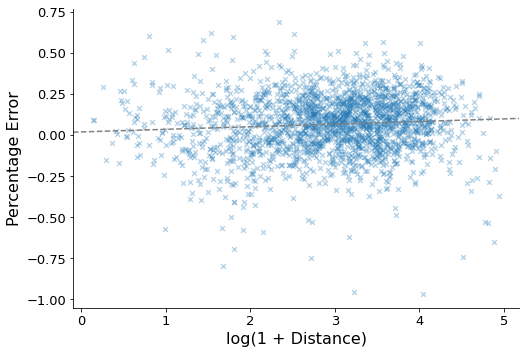

In [97]:
fig, ax = plt.subplots(figsize = (8, 5.5))

ax.scatter(
    'log_distance', 'pc_err', data = fig_data,
    marker = 'x', s = 23, alpha = 0.3
)

model = sm.OLS(fig_data['pc_err'], sm.add_constant(fig_data['log_distance'])).fit()
abline_plot(model_results = model, ax = ax, linestyle = 'dashed', color = 'grey')
r2 = model.rsquared

# ax.set_title(f"Predictibility of the Discrepancy ($R^2$: {r2:.2e})", size = 20)
ax.set_ylabel("Percentage Error", size = 16)
ax.set_xlabel("log(1 + Distance)", size = 16)

#ax.set_ylim((0, 6500))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis = 'y', labelsize = 13)
ax.tick_params(axis = 'x', labelsize = 13)

print(r2)
plt.savefig(fr"zori_pcerr_dist.pdf", bbox_inches = 'tight')

#### Panel C - ACS vs. ZORI

In [98]:
table_data = pd.read_stata(r"..\Data\Intermediate\zori_mi_analysis_data.dta")

0.810536535558825


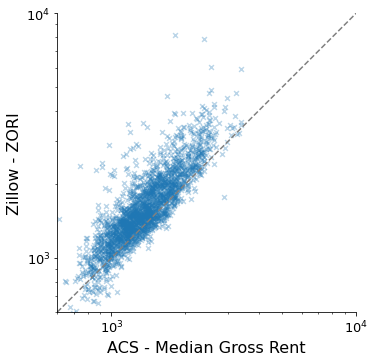

In [99]:
fig_data = table_data \
    .loc[table_data['month'].between('2015-01-01', '2019-12-01')] \
    .groupby('zip')[['cns_median_rent', 'ZORI', 'log_distance']].agg('mean') \
    .reset_index()

fig_data = fig_data[
    (fig_data['cns_median_rent'].notna()) &
    (fig_data['ZORI'].notna())
]

fig, ax = plt.subplots(figsize = (8, 5.5))

ax.scatter(
    'cns_median_rent', 'ZORI', data = fig_data,
    marker = 'x', s = 23, alpha = 0.3
)

corr = fig_data.loc[(fig_data['cns_median_rent'].notna()) & 
                    (fig_data['ZORI'].notna()),
                    'cns_median_rent'] \
    .corr(fig_data.loc[(fig_data['cns_median_rent'].notna()) & 
                    (fig_data['ZORI'].notna()),
                    'ZORI'])

ax.set_ylabel("Zillow - ZORI", size = 16)
ax.set_xlabel("ACS - Median Gross Rent", size = 16)

ax.set_yscale('log')
ax.set_ylim(bottom = 0.6*1e3, top = 1e4)
ax.set_xscale('log')
ax.set_xlim(left = 0.6*1e3, right = 1e4)
ax.set_aspect('equal')

ax.axline([0, 0], [1, 1], linestyle = 'dashed', color = 'grey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis = 'y', labelsize = 13)
ax.tick_params(axis = 'x', labelsize = 13)

print(corr)
plt.savefig(fr"ZORI_vs_ACS-rent_comb_new.pdf", bbox_inches = 'tight')

#### Panel D - ACS Log Diff. vs. Distance

C:\Users\lz2692\Anaconda3\envs\nycempty\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.017288476116344542


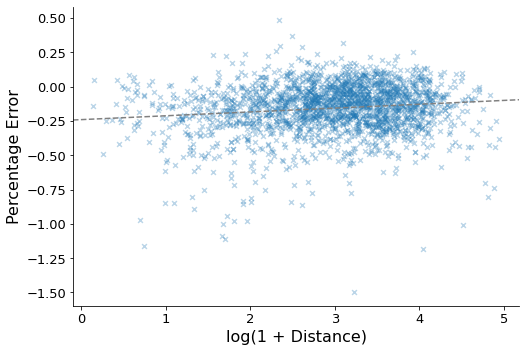

In [100]:
fig_data = table_data \
    .loc[table_data['month'].between('2015-01-01', '2019-12-01')] \
    .groupby('zip')[['cns_median_rent', 'ZORI', 'log_distance']].agg('mean') \
    .reset_index()

fig_data = fig_data[
    (fig_data['cns_median_rent'].notna()) &
    (fig_data['ZORI'].notna())
]

# fig_data = table_data[
#     (table_data['month'] == '2019-12') &
#     (table_data['cns_median_rent'].notna()) &
#     (table_data['ZORI'].notna())
# ]

fig_data['std_err'] = np.abs(fig_data['cns_median_rent'] - fig_data['ZORI'])
fig_data['pc_err'] = np.log(fig_data['cns_median_rent']) - np.log(fig_data['ZORI'])

fig, ax = plt.subplots(figsize = (8, 5.5))

ax.scatter(
    'log_distance', 'pc_err', data = fig_data,
    marker = 'x', s = 23, alpha = 0.3
)

model = sm.OLS(fig_data['pc_err'], sm.add_constant(fig_data['log_distance'])).fit()
abline_plot(model_results = model, ax = ax, linestyle = 'dashed', color = 'grey')
r2 = model.rsquared

# ax.set_title(f"Predictibility of the Discrepancy ($R^2$: {r2:.2e})", size = 20)
ax.set_ylabel("Percentage Error", size = 16)
ax.set_xlabel("log(1 + Distance)", size = 16)

#ax.set_ylim((0, 6500))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis = 'y', labelsize = 13)
ax.tick_params(axis = 'x', labelsize = 13)

print(r2)
plt.savefig(fr"zori-ACS_pcerr_dist_new.pdf", bbox_inches = 'tight')

#### Panel E - ApartmentList vs. ZORI

#### Panel F - ApartmentList Log Diff. vs. Distance

### Figure B2 - Correlation Between CPI Rent of Primary Residence and ZORI at MSA level
See STATA Code

### Figure B3 - Relationship between Distance and Rentership

In [101]:
table_data = pd.read_stata(r"..\Data\Intermediate\zori_mi_analysis_data.dta")

#### Panel A - Rentership vs. Distance

C:\Users\lz2692\Anaconda3\envs\nycempty\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


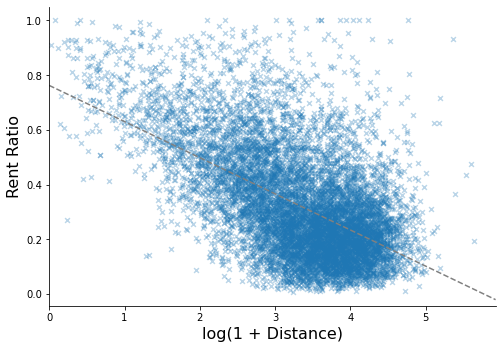

In [102]:
fig, ax = plt.subplots(figsize = (8, 5.5))

fig_data = table_data[(table_data['month'] == '2020-01') & (table_data['cns_renter_ratio'] > 0)]

ax.scatter('log_distance', 'cns_renter_ratio', data = fig_data,
          marker = 'x', s = 23, alpha = 0.3
    )

model = sm.OLS(fig_data['cns_renter_ratio'], sm.add_constant(fig_data['log_distance'])).fit()
abline_plot(model_results = model, ax = ax, linestyle = 'dashed', color = 'grey')

ax.set_ylabel("Rent Ratio", size = 16)
ax.set_xlabel("log(1 + Distance)", size = 16)

ax.set_xlim(left = 0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(fr"renter_ratio_dist_new.pdf", bbox_inches = 'tight')

#### Panel B - ZORI Coverage vs. Distance

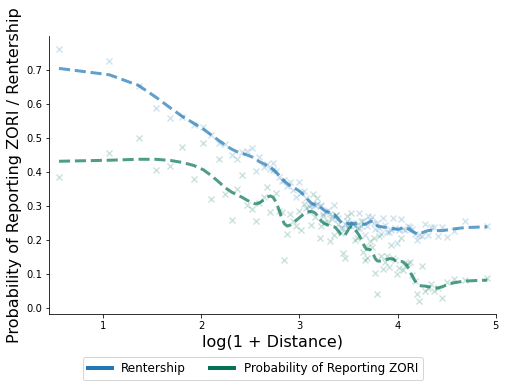

In [103]:
fig, ax = plt.subplots(figsize = (8, 5.5))

fig_data = table_data[table_data['month'] == '2020-01'].groupby('log_dist_qs').mean()

ax.scatter('log_distance', 'cns_renter_ratio', data = fig_data,
          marker = 'x', color = 'tab:blue', alpha = 0.2)

ax.plot(fig_data['log_distance'], gaussian_filter1d(fig_data['cns_renter_ratio'], 2),
        linewidth = 3, linestyle = '--', color = 'tab:blue', alpha = 0.7)

ax.scatter('log_distance', 'ZORI_avail', data = fig_data,
          marker = 'x', color = '#037357', alpha = 0.2)

ax.plot(fig_data['log_distance'], gaussian_filter1d(fig_data['ZORI_avail'], 2),
        linewidth = 3, linestyle = '--', color = '#037357', alpha = 0.7)

ax.set_ylabel("Probability of Reporting ZORI / Rentership", size = 16)

ax.set_xlabel("log(1 + Distance)", size = 16)
ax.set_xlim((fig_data['log_distance'].min()-0.1, 5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

custom_lines = [Line2D([0], [0], color = 'tab:blue', lw=4),
                Line2D([0], [0], color = '#037357', lw=4)]

corr = fig_data[['cns_renter_ratio', 'ZORI_avail']].corr().iloc[0,1]

plt.subplots_adjust(bottom = 0.18)

fig.legend(custom_lines, ['Rentership', 'Probability of Reporting ZORI'], 
           loc = "lower center", 
           fontsize = 12, ncol = 3)

plt.savefig(fr"renter-probZori_dist_new.pdf", bbox_inches = 'tight')

### Figure C1 - Change in Urban Minus Suburban Rent Growth Relative to Pre-Pandemic for Combination of Transitory and Permanent Regime
See STATA Code

### Figure C2 - Evolution of Price-Rent Ratio when Pandemic is Transitory and Permanent along with a Combination of Two Regimes
See STATA Code